In [1]:
!pip install bs4

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [3]:
import requests 
from bs4 import BeautifulSoup 
import html5lib

## Processing of toronto dataset and created toronto_data_set.csv

In [4]:
URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
r = requests.get(URL) 
soup = BeautifulSoup(r.content, 'html5lib') 

table = soup.find('table')
data = {'Postal Code': list(), 'Borough': list(), 'Neighborhood': list()}
for row in table.findAll('tr'): 
    splits = str(row).split('\n')
    code = splits[1].split('>')[1]
    borough = splits[3].split('>')[1]
    neighbor = splits[5].split('>')[1]
    if not (borough == 'Not assigned' or borough == 'Borough'):
        data['Postal Code'].append(code)
        data['Borough'].append(borough)
        data['Neighborhood'].append(neighbor.replace('/', ','))
        
toronto_df = pd.DataFrame(data, columns=('Postal Code', 'Borough', 'Neighborhood'))
data = pd.read_csv('Geospatial_Coordinates.csv')

Latitude = list()
Longitude = list()

for row in toronto_df['Postal Code']:
    lat = data[data['Postal Code'] == row]
    Latitude.append(str(lat['Latitude']).split()[1])
    Longitude.append(str(lat['Longitude']).split()[1])
    
toronto_df['Latitude'] = Latitude
toronto_df['Longitude'] = Longitude
toronto_df.drop(['Postal Code'], axis=1, inplace=True)
# toronto_df.to_csv('toronto_data_set.csv', index=None)

## Processing of neywork dataset to created manhattan_data_set.csv

In [5]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
manhattan_df = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
# manhattan_data.to_csv('manhattan_data_set.csv', index=None)

## foursquare API info...

In [6]:
CLIENT_ID = 'XB5250OGQ0DUG3SJPTCSGZL4CSXRK3LMMQTC3IYSJZUITSCK' # your Foursquare ID
CLIENT_SECRET = 'ZPNHLLVWQ0TKF3DWDKPHI23XHNRF5NEPNMIFJPYJW5CE5TLL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius = 500
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XB5250OGQ0DUG3SJPTCSGZL4CSXRK3LMMQTC3IYSJZUITSCK
CLIENT_SECRET:ZPNHLLVWQ0TKF3DWDKPHI23XHNRF5NEPNMIFJPYJW5CE5TLL


In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Preprocessing of toronto data

In [8]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude'])

In [10]:
manhattan_venues = getNearbyVenues(names=manhattan_df['Neighborhood'],
                                   latitudes=manhattan_df['Latitude'],
                                   longitudes=manhattan_df['Longitude'])

In [11]:
toronto_venues.shape

(2151, 7)

In [12]:
manhattan_venues.shape

(2984, 7)

In [13]:
data_venues = pd.concat([toronto_venues, manhattan_venues])

In [14]:
data_venues.shape

(5135, 7)

In [15]:
data_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood , Long Branch",10,10,10,10,10,10
"Bathurst Manor , Wilson Heights , Downsview North",19,19,19,19,19,19
Battery Park City,57,57,57,57,57,57
Bayview Village,4,4,4,4,4,4


In [16]:
# one hot encoding
data_onehot = pd.get_dummies(data_venues[['Venue Category']], prefix="", prefix_sep="")
data_onehot.shape

(5135, 383)

In [17]:
lst = (list(data_onehot.columns))
lst.remove('Neighborhood')
len(lst)

382

In [18]:
# move neighborhood column to the first column
fixed_columns = ['Neighborhood'] + lst
data_onehot = data_onehot[fixed_columns]

data_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persi

In [19]:
# add neighborhood column back to dataframe
data_onehot['Neighborhood'] = data_venues['Neighborhood']
data_onehot.shape

(5135, 383)

In [20]:
data_grouped = data_onehot.groupby('Neighborhood').mean().reset_index()
# data_grouped

In [21]:
data_grouped.shape

(133, 383)

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
data_venues_sorted = pd.DataFrame(columns=columns)
data_venues_sorted['Neighborhood'] = data_grouped['Neighborhood']

for ind in np.arange(data_grouped.shape[0]):
    data_venues_sorted.iloc[ind, 1:] = return_most_common_venues(data_grouped.iloc[ind, :], num_top_venues)

data_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Breakfast Spot,Lounge,Clothing Store,Skating Rink,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner
1,"Alderwood , Long Branch",Pizza Place,Coffee Shop,Pub,Sandwich Place,Athletics & Sports,Pharmacy,Dance Studio,Gym,Skating Rink,Dumpling Restaurant
2,"Bathurst Manor , Wilson Heights , Downsview North",Coffee Shop,Bank,Sandwich Place,Gas Station,Middle Eastern Restaurant,Diner,Fried Chicken Joint,Deli / Bodega,Restaurant,Shopping Mall
3,Battery Park City,Park,Hotel,Gym,Memorial Site,Boat or Ferry,Food Court,Beer Garden,Wine Shop,Gourmet Shop,Plaza
4,Bayview Village,Chinese Restaurant,Bank,Café,Japanese Restaurant,Yoga Studio,Electronics Store,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant


In [24]:
data_venues_sorted.shape

(133, 11)

In [25]:
data_venues_sorted['Neighborhood'].head()

0                                            Agincourt
1                              Alderwood , Long Branch
2    Bathurst Manor , Wilson Heights , Downsview North
3                                    Battery Park City
4                                      Bayview Village
Name: Neighborhood, dtype: object

In [26]:
# data_venues_sorted['region'] = region
# data_venues_sorted.drop('region', axis=1, inplace=True)
data_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Breakfast Spot,Lounge,Clothing Store,Skating Rink,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner
1,"Alderwood , Long Branch",Pizza Place,Coffee Shop,Pub,Sandwich Place,Athletics & Sports,Pharmacy,Dance Studio,Gym,Skating Rink,Dumpling Restaurant
2,"Bathurst Manor , Wilson Heights , Downsview North",Coffee Shop,Bank,Sandwich Place,Gas Station,Middle Eastern Restaurant,Diner,Fried Chicken Joint,Deli / Bodega,Restaurant,Shopping Mall
3,Battery Park City,Park,Hotel,Gym,Memorial Site,Boat or Ferry,Food Court,Beer Garden,Wine Shop,Gourmet Shop,Plaza
4,Bayview Village,Chinese Restaurant,Bank,Café,Japanese Restaurant,Yoga Studio,Electronics Store,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant


In [27]:
data_grouped.shape

(133, 383)

In [28]:
# set number of clusters
kclusters = 5

data_grouped_clustering = data_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0], dtype=int32)

In [29]:
# add clustering labels
data_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [30]:
region = list()
for i in data_venues_sorted['Neighborhood']:
    if i in set(toronto_venues['Neighborhood']):
        region.append('toronto')
    else:
        region.append('manhattan')

In [31]:
data_venues_sorted['region'] = region

In [32]:
cluster1 = data_venues_sorted[data_venues_sorted['Cluster Labels'] == 0]
cluster2 = data_venues_sorted[data_venues_sorted['Cluster Labels'] == 1]
cluster3 = data_venues_sorted[data_venues_sorted['Cluster Labels'] == 2]
cluster4 = data_venues_sorted[data_venues_sorted['Cluster Labels'] == 3]
cluster5 = data_venues_sorted[data_venues_sorted['Cluster Labels'] == 4]

In [39]:
(cluster2['region'].value_counts())

toronto    9
Name: region, dtype: int64

In [40]:
clusters = ['cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5']
toronto = [cluster1['region'].value_counts()[0], 
           cluster2['region'].value_counts()[0], 
           cluster3['region'].value_counts()[0], 
           cluster4['region'].value_counts()[0], 
           cluster5['region'].value_counts()[0]]
manhattan = [40, 0, 0, 0, 0]

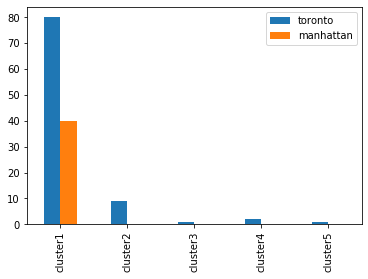

In [43]:
df = pd.DataFrame({'toronto': toronto, 'manhattan': manhattan}, index=clusters)
df.plot.bar()

## As shown in above diagram 